# Testing MiniscoPy with artificial data

MiniscopPy is a Python 3.0 implementation of the CNMF-E algorithm (Zhou et al., 2016). It has been optimized for the MiniScope (Cai et al., 2016), a portable microscope for calcium imaging in freely moving animals.

This notebook will guide you through the MiniscoPy package step by step. After generating artificial calcium images, you will see how to extract calcium transients and decode sensory signals. To this end, we used an artificial signal associated with an angular value (e.g. head-direction or visual orientation).


# Basic imports

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from matplotlib.pyplot import *
import pandas as pd
import sys, tempfile
import cv2
import brian2.only as br2
from IPython.core.debugger import Pdb
import h5py as hd
#specific to miniscopy
from miniscopy.base.motion_correction import *
from miniscopy import setup_cluster, CNMFE, generate_data, get_default_parameters

# Generating a Head-Direction (HD) signal

Simulation for a HD tracking at 100 Hz, for 10 seconds.
The agent rotates on average at $\frac{\pi}{2}/s$

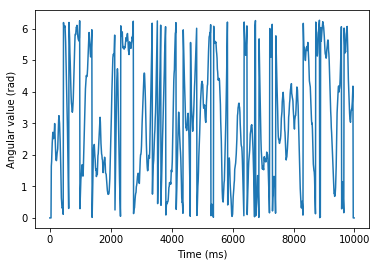

In [21]:
bin_size = 10 #ms
duration = 10000 #ms
hd_signal = pd.Series(index = np.arange(0, duration, bin_size), data = 0)
# the agent rotates on average at pi/2/s
for i in range(1,len(hd_signal)):
    hd_signal.iloc[i] = hd_signal.iloc[i-1] + np.random.normal((np.pi/2)*(bin_size/1000),1)
hd_signal = hd_signal.rolling(center=True, window=10).mean().fillna(0)
hd_signal = hd_signal%(2*np.pi)

# plotting of the head-direction signal
plot(hd_signal)
xlabel("Time (ms)")
ylabel("Angular value (rad)")
show()

# GENERATE SPIKING ACTIVITY WITH BRIAN2
Here we simulate 20 head-direction neurons with __[BRIAN](http://brian2.readthedocs.io/en/stable/index.html#)__, a very cool tool to do spiking simulation.
Spikes are counted in bins of 10 ms.


Starting simulation at t=0. s for a duration of 10. s
10.0 (100%) simulated in 1s


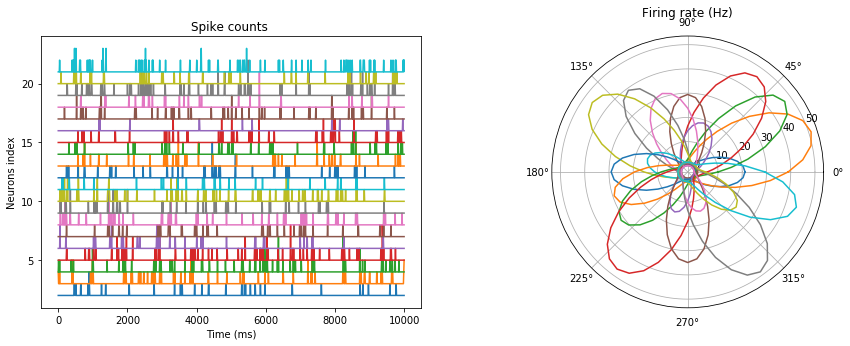

In [24]:
def get_tuning_curves(n, nb_bins):    
    x   = np.linspace(0, 2*np.pi, nb_bins+1)
    phi = np.linspace(0, 2*np.pi, n+1)[0:-1]
    A   = np.random.uniform(10, 50,n)
    B   = np.random.uniform(5, 10, n)
    C   = np.random.uniform(0, 2, n)
    return pd.DataFrame(index = x, columns = np.arange(n), data = C+A*np.exp(B*np.cos(np.vstack(x) - phi))/np.exp(B))

N = 20 # number of neurons
tcurves     = get_tuning_curves(N, nb_bins = 60)
freq_steps  = tcurves.reindex(hd_signal, method = 'nearest').values
# brian2 simulation
br2.BrianLogger.log_level_info()
network     = br2.Network()
stim_hd     = br2.TimedArray(freq_steps*br2.Hz, dt = float(bin_size)*br2.ms)
network.add(br2.PoissonGroup(N, rates = 'stim_hd(t, i)'))
network.add(br2.SpikeMonitor(network.objects[0]))
network.run(duration*br2.ms, report = 'text')
spikes      = network.objects[2].spike_trains()
del network

# the spike count
spike_count  = pd.DataFrame(index = hd_signal.index)
for k in spikes.keys():    
    spike_count[k], bins_edge = np.histogram(spikes[k]/br2.ms, int(duration/bin_size), range = (0, duration))

# plotting the spike count and the tuning curves of the neurons
figure(figsize = (15,5))
subplot(121)
for i in spike_count:
    plot(spike_count[i]+i+2)
xlabel('Time (ms)')
ylabel('Neurons index')
title("Spike counts ")
subplot(122, projection = 'polar')
for i in tcurves:
    plot(tcurves[i])
title('Firing rate (Hz)')
show()


# GENERATING A CALCIUM IMAGING MOVIE & SAVING IN HDF5
With real data, the transfert of the movie (avi) files to a HDF5 file is automatically done with the motion correction algorithm function. Here, we skip this step.

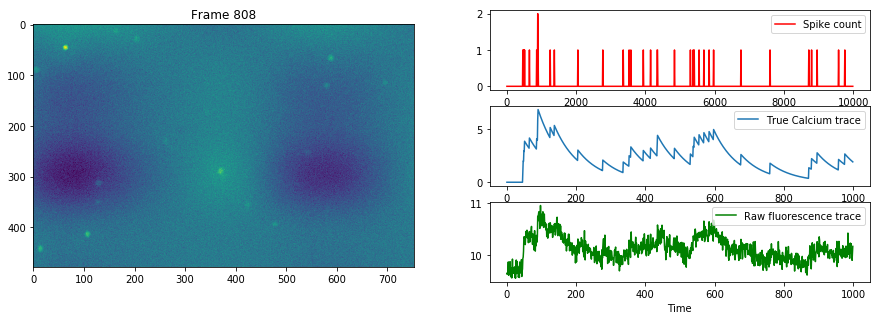

In [38]:
dims = (480, 752) # dimension of a frame with the miniscope
movie, true_data = generate_data(spike_count.values, N, duration//bin_size, dims, framerate = 1/(bin_size*1e-3))

# create a temporary hdfile
# path = tempfile.mkdtemp()
path = '/mnt/DataGuillaume/MINISCOPE/test_hd_video'
filename = path + '/test_hd.hdf5'
try:
    data.close()
except:
    pass
data = hd.File(filename, "w")
data.create_dataset('movie', data = movie.astype('float32'), chunks=True) # the chunking is important

# need to set some attributes to match the type of file created by the motion correction algorithm 
data.attrs['folder']            = path
data.attrs['filename']          = filename
data['movie'].attrs['duration'] = movie.shape[0]
data['movie'].attrs['dims']     = dims

import matplotlib.gridspec as gridspec
figure(figsize = (15,5))
gs = gridspec.GridSpec(3, 2)
# let's have a look at one random image from the movie
subplot(gs[:,0])        
fr = np.random.randint(0,movie.shape[0])
imshow(movie[fr].reshape(dims))
title("Frame "+str(fr))
# as well as the calcium trace of one neuron and compare it with the spike count
subplot(gs[0,1])
plot(spike_count[0], label = 'Spike count', color = 'red')
subplot(gs[1,1])
plot(true_data['C'][:,0], label = 'True Calcium trace')
legend()
subplot(gs[2,1])
r, c = true_data['center'][0] # row and column pixel position of the first neuron
plot(movie[:,r*dims[1]+c], color = 'green', label = 'Raw fluorescence trace')
legend()
xlabel("Time")
show()

# RUNNING CNMF-E ON THE GENERATED DATA
A file called parameters.yaml should be in each recording folder and be loaded at the beginning of the script (see README).
The default parameters of MiniscoPy/CNMFE are the same as in the __[CaiMan](https://github.com/flatironinstitute/CaImAn)__ package (e.g. size of neurons and fitler parameters). Here, they were tuned for best performance with the generated data. 
__DO NOT USE THESE PARAMETERS WITH REAL DATA. IT'S BETTER TO STICK WITH THE DEFAULT PARAMETERS UNLESS YOU KNOW WHAT YOU'RE DOING.__


In [39]:
c, procs, n_processes = setup_cluster(backend='local', n_processes=8, single_thread=False)

parameters = get_default_parameters('cnmfe')
# need to change thresh_init to not supress too much pixels when initiating
# do not use for real data unless you know why
parameters['init_params']['thresh_init'] = 0.5
parameters['init_params']['min_pnr'] = 1.5
parameters['init_params']['min_corr'] = 0.6
parameters['init_params']['gSig'] = (4,4)
parameters['init_params']['gSiz'] = (12,12)
parameters['init_params']['filter_data_centering'] = False # new parameter | not in CAIMAN

cnm = CNMFE(data, parameters)
cnm.fit(procs)

  0%|          | 0/12 [00:00<?, ?it/s]

Fitting patch


  0%|          | 0/9 [00:00<?, ?it/s]

Starting assemble_patch
Initializing hdf5 file


  0%|          | 0/10 [00:00<?, ?it/s]

Compressing background


100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Merging components
No neurons merged!
Total time :  518.3536  second


Let's see if CNMF-E found the correct spatial position.

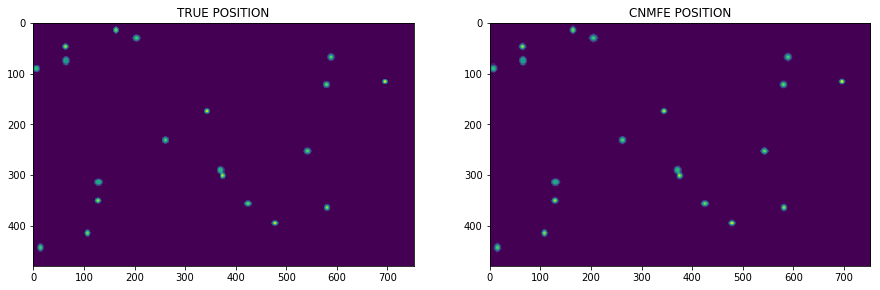

In [44]:
figure(figsize = (15,5))
subplot(121)
imshow(true_data['A'].sum(0).reshape(dims))
title("TRUE POSITION")
subplot(122)
title("CNMFE POSITION")
imshow(cnm.A.value.sum(0).reshape(dims))
show()

Now we can compare the output of CNMFE with the true calcium traces. But before that, we need to match the spatial patches uncovered by CNMF-E with our ground-truth. We do it by finding the closest match for each spatial patch.

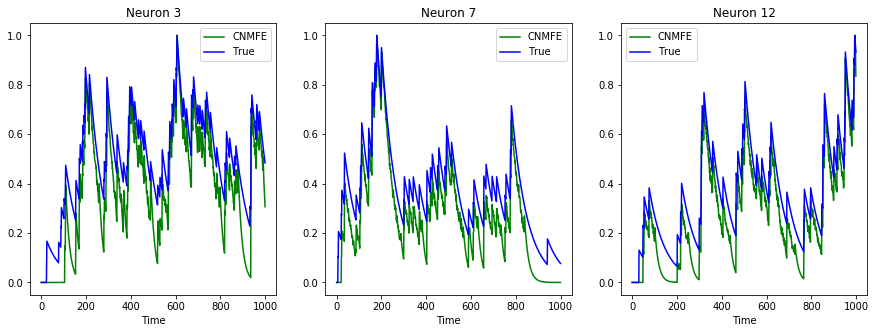

In [49]:
# need to sort the cnmfe neurons by the position of the centers
true_C = true_data['C']
new_C = np.zeros_like(true_C)
idx_sorted = np.zeros(len(cnm.center), dtype=np.int)
for i in range(len(cnm.center)):
    idx = np.sqrt(np.power(cnm.center[i] - true_data['center'],2).sum(1)).argmin()
    idx_sorted[i] = idx
    new_C[:,idx] = cnm.C[:,i]

# normalize each trace between 0 and 1 to compare
new_C -= new_C.min(0)
new_C /= new_C.max(0)
true_C -= true_C.min(0)
true_C /= true_C.max(0)

# let's plot 3 random neurons
index_neurons = np.sort(np.random.choice(np.arange(N), 3))
figure(figsize = (15,5))
for i, idx in enumerate(index_neurons):
    subplot(1,3,i+1)
    plot(new_C[:,idx], label = 'CNMFE', color = 'green')
    plot(true_C[:,idx], label = 'True', color = 'blue')
    xlabel("Time")
    title("Neuron "+str(idx))
    legend()
show()

# DECODING THE HEAD-DIRECTION FROM CALCIUM TRACES WITH XGBOOST
Because why bother doing Bayesian decoding when tools such as __[XGBoost](http://xgboost.readthedocs.io/en/latest/)__ exists. See also __[NeuroBoostedTree](https://github.com/PeyracheLab/NeuroBoostedTrees)__

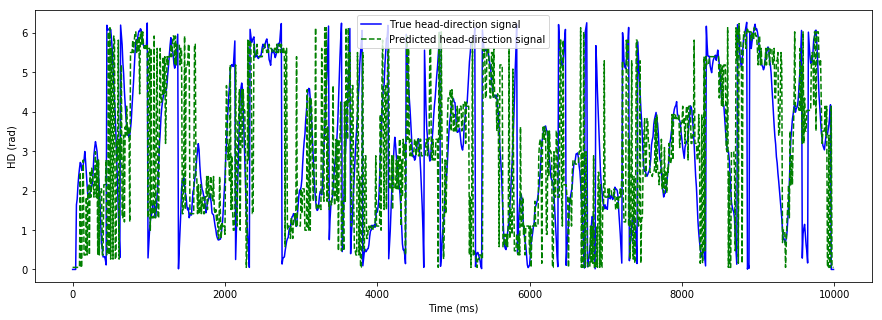

In [54]:
from sklearn.model_selection import KFold
import xgboost as xgb

def xgb_decodage(Xr, Yr, Xt):      
    params = {'objective': "multi:softprob", 'eval_metric': "mlogloss", #loglikelihood loss
    'seed': 2925, #for reproducibility
    'silent': 1, 'learning_rate': 0.01, 'min_child_weight': 2, 'n_estimators': 1000, 'max_depth': 5, 'gamma': 0.5,
    'num_class':60}    
    # binning Yr in 60 classes
    bins = np.linspace(0, 2*np.pi+1e-8, 61)
    clas = np.digitize(Yr, bins).flatten()-1
    x = bins[0:-1] + (bins[1]-bins[0])/2.    
    dtrain = xgb.DMatrix(Xr, label=clas)
    dtest = xgb.DMatrix(Xt)
    num_round = 100
    bst = xgb.train(params, dtrain, num_round)    
    ymat = bst.predict(dtest)
    return x[np.argmax(ymat,1)]

def fit_cv(X, Y, n_cv=10):
    # The function to do the cross-validation
    cv_kf = KFold(n_splits=n_cv, shuffle=True, random_state=42)
    skf  = cv_kf.split(X)    
    Y_hat=np.zeros(len(Y))        
    for idx_r, idx_t in skf:        
        Yt_hat = xgb_decodage(X[idx_r, :], Yr = Y[idx_r], Xt = X[idx_t, :])
        Y_hat[idx_t] = Yt_hat        
    return Y_hat

# cnm.C is put in a panda dataframe that should become soon a neuroseries object
C = pd.DataFrame(new_C, columns = np.arange(N))

hd_predicted = fit_cv(C.values, hd_signal.values, n_cv = 4)
hd_predicted = pd.Series(data = hd_predicted, index = hd_signal.index)

figure(figsize = (15,5))
plot(hd_signal, label = 'True head-direction signal', color = 'blue')
plot(hd_predicted, '--', label = 'Predicted head-direction signal', color = 'green')
legend()
xlabel("Time (ms)")
ylabel("HD (rad)")
show()